## Recreating Your Spotify Taste Map with KMeans

Spotify launched their Discover Weekly playlists in 2015, and it has been a great success. The secret? A mixture of collaborative filtering with music from other users, and a profile of each user’s music tastes. A Quartz Editor got an exclusive look into the inner workings of the system and a beautiful visual representation of their taste profile. 

This notebook will explore the taste profile aspect of the system, which is grouped into clusters of artists and micro-genres. I'll be making use of machine learning concepts and methods to group a user's music into these micro-genres and recreate the taste profile visualizations. 

Of course, I don't have access to as much data as Spotify has about listeners, or the advanced deep learning knowledge to create a copy of the algorithms. I'll be going through the process of obtaining the data, selecting features, clustering, labelling, and verifying the implementation. 

### Setup

If you have cloned this repository and are running this locally, you should create a Spotify app and define a `.env` file in the `/python` directory with the contents below. 
```
CLIENT_ID="your_spotify_app_id"
CLIENT_SECRET="your_spotify_app_secret"
USER_ID="your_spotify_username"
```

**Importing the required libraries**

We'll be using the `spotipy` library to obtain Spotify data, `dotenv` to load the env variables from the `.env` file, `pandas` to manipulate our data, `sklearn` for machine learning functions for analysis, and `matplotlib` and `seaborn` to plot our graphs. 

In [1]:
import os, json
from dotenv import load_dotenv
from collections import defaultdict

import spotipy
import spotipy.util as util

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import circlify as circ

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
# loads and sets API keys
load_dotenv()

client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')
user_id = os.getenv("USER_ID")

# redirect uri and scope for obtaining Spotify token
redirect_uri = "http://localhost:9999"
scope = 'user-library-read, playlist-modify-public, user-top-read'

Now that we have set the variables for Spotify, we can initialize `spotipy` and send a request for my top songs. 

In [3]:
# obtains user token from Spotify
token = util.prompt_for_user_token(user_id, scope=scope, client_id=client_id, \
                                   client_secret=client_secret, redirect_uri=redirect_uri)
sp = spotipy.Spotify(auth = token)

In [4]:
# make request for my top tracks
top_tracks = sp.current_user_top_tracks(limit=49, time_range="long_term")
songs = top_tracks["items"]
top_tracks = sp.next(top_tracks) # there are 2 pages of top tracks
songs.extend(top_tracks['items'])

**Get audio features for top tracks**

We now have the top songs, but not any useful parameters for them. We can use Spotify's audio features endpoint to get that information for this list of songs we have. We also want to keep some metadata from the tracks in an object for easier reading. Now we move the data into DataFrames, dropping unrelated properties like `analysis_url`, `track_href`, etc. 

In [5]:
# get list of track ids to send to Spotify audio features endpoint, and keep track of metadata
trkid = []
trkname = []
artistid = set()
for track in songs:
  trkid.append(track["id"])
  artistid.add(track["artists"][0]["id"])
  trkname.append({
      "name": track["name"], 
      "id": track["id"], 
      "artist": track["artists"][0]["name"]
  })

# get audio features for list of songs
audiofeatures = sp.audio_features(trkid)

In [6]:
# gets artist genres for list of artist ids
count = 50
artistid = list(artistid)
artists = []
while count < len(artistid):
    artists.extend(sp.artists(artistid[:count])["artists"])
    count += 50
artists.extend(sp.artists(artistid[count - 50:])["artists"])

# format artist genres and add into array of objects
artistgenres = []
for art in artists:
    artistgenres.append({"name": art["name"], "genres": art["genres"]})

for i in range(len(trkname)):
    for art in artistgenres:
        if trkname[i]["artist"] == art["name"]:
            trkname[i]["genres"] = art["genres"]

In [7]:
# create dataframe for the metadata
top_tracks_names = pd.DataFrame(trkname)

# create df for audio features, dropping unrelated properties
top_tracks_audiofeat_df = pd.DataFrame(audiofeatures).drop(
    ['analysis_url', 'track_href', 'type', 'uri'], axis=1)
top_tracks_df = top_tracks_names.merge(top_tracks_audiofeat_df, on="id")

# preview the data we have so far
print("tracks: %d" % top_tracks_df.shape[0])
top_tracks_df.head()

tracks: 98


,name,id,artist,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Freak (feat. Bonn),6NVjujGb9fnl25fjzm5dTy,Avicii,"[big room, dance pop, edm, pop]",0.405,0.576,8,-6.245,1,0.1710,0.2250,0.000008,0.0822,0.695,91.204,179479,4
1,Holes - Radio Edit,77w4HJEAGzRwHTapyXjFl1,Passenger,"[folk-pop, neo mellow, pop, pop rock]",0.369,0.591,4,-6.370,1,0.1020,0.3290,0.000003,0.0762,0.548,158.399,218613,1
2,Nervous (The Ooh Song) - Mark McCabe Remix,0L9lXMXddmoBbBUeF7A9An,Gavin James,"[irish pop, neo mellow, pop, pop rock, viral pop]",0.432,0.874,7,-5.558,1,0.0462,0.0732,0.000006,0.3710,0.374,103.850,195195,4
3,The Wrong Direction,7FMEEYbIfiEazN02exf120,Passenger,"[folk-pop, neo mellow, pop, pop rock]",0.689,0.666,5,-6.352,1,0.0372,0.3640,0.000000,0.0925,0.800,127.993,221373,4
4,Let Her Go,7DFNE7NO0raLIUbgzY2rzm,Passenger,"[folk-pop, neo mellow, pop, pop rock]",0.509,0.538,7,-7.335,1,0.0572,0.3850,0.000000,0.1040,0.244,75.089,252867,4


### Preprocessing

With the tracks obtained, we still have some steps to take before running our k-means algorithm. We want to normalize the features so that they all have equal weight, otherwise we'll likely get songs grouped by `duration_ms` due to the large values. Then, we want to remove any highly correlated features from the matrix to remove redundancy. 

**Normalize the audio features data**

We'll define all the operations we perform on the data in functions for reusability. 

In [8]:
def NormalizeFeatures(top_tracks_audiofeat_df):
    """Function to normalize feature values
    top_tracks_audiofeat_df : DataFrame
    """
    audio_features_scaler = StandardScaler()
    # drop all the non-relevant columns for scaling, like id, track name, artist name
    scaled_features = audio_features_scaler.fit_transform(
        top_tracks_audiofeat_df.drop("id", axis=1))
    scaled_features_df = pd.DataFrame(
        scaled_features, columns=top_tracks_audiofeat_df.drop('id', axis=1).columns)
    scaled_features_df["id"] = top_tracks_audiofeat_df["id"]
    return scaled_features_df

scaled_features_df = NormalizeFeatures(top_tracks_audiofeat_df)
scaled_features_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id
0,-2.154371,-0.367621,0.781451,0.377943,0.61667,3.155800,-0.202629,-0.196762,-0.755193,1.407127,-0.968979,-1.029051,0.2,6NVjujGb9fnl25fjzm5dTy
1,-2.516512,-0.275402,-0.316502,0.322355,0.61667,1.249226,0.221759,-0.196815,-0.827268,0.525891,2.255589,0.348776,-8.2,77w4HJEAGzRwHTapyXjFl1
2,-1.882765,1.464460,0.506963,0.683458,0.61667,-0.292612,-0.822073,-0.196784,2.714012,-0.517205,-0.362120,-0.475723,0.2,0L9lXMXddmoBbBUeF7A9An
3,0.702521,0.185692,-0.042014,0.330360,0.61667,-0.541296,0.364582,-0.196854,-0.631464,2.036582,0.796460,0.445950,0.2,7FMEEYbIfiEazN02exf120
4,-1.108185,-0.601242,0.506963,-0.106789,0.61667,0.011335,0.450276,-0.196854,-0.493321,-1.296529,-1.742309,1.554788,0.2,7DFNE7NO0raLIUbgzY2rzm


**Omit redundant features**

<Figure size 432x288 with 0 Axes>

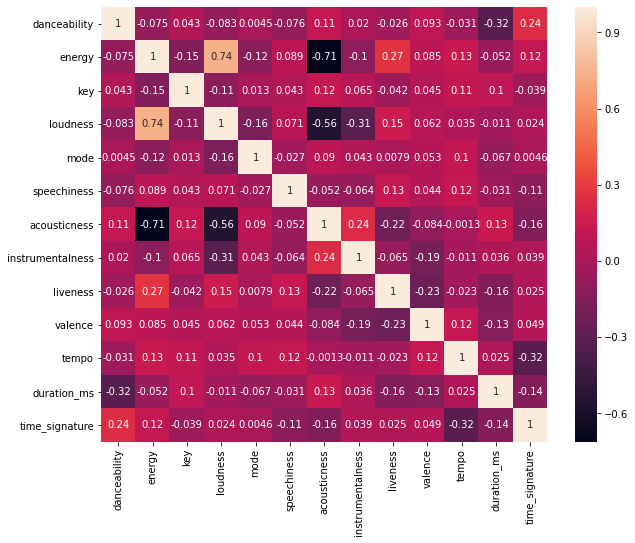

In [9]:
# Correlation Matrix
plt.tight_layout()
plt.figure(figsize=(10, 8))
corrMatrix = scaled_features_df.drop(['id'], axis=1).corr()
sn.heatmap(corrMatrix, annot=True);

We can plot a correlation matrix to view how independent the variables are to each other. We see that loudness and energy are highly correlated, as well as acousticness and energy. So, we'll remove loudness to reduce the noise in the algorithm, and increase efficiency and intepretability. 

Another thing that we can do is looking through the features manually and selecting only the ones that will help reach our target. From that analysis, time_signature, key, and mode can potentially be removed too, but it's a personal preference. 

In [10]:
scaled_features_df = scaled_features_df.drop(["loudness", "key", "time_signature", "mode"], axis=1)

### Principle Component Analysis

PCA is the main method we'll be using to recreate the visualizations through dimensionality reduction. By transforming the data to a new coordinate system, we are able to visualize high-dimensional data in a 2d plot. Let's take a look at my top songs visualized, and the variance shown with the two PCA combinations that explain the data. 

In [11]:
# Set up PCA
pca = PCA()
principal_comp = pca.fit_transform(
    scaled_features_df.drop(["id"], axis=1))
PCA_comp = pd.DataFrame(principal_comp)

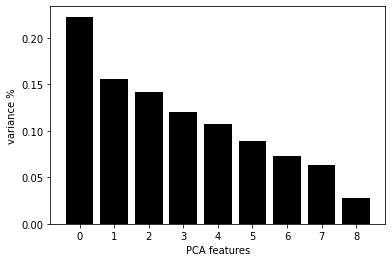

In [12]:
# Plot PCA
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features);

We can see that the first two PCA features explain about 30% of the variance in the data. This isn't too great, but is probably sufficient to plot the relationship between songs, since they are such subjective data. Now let's plot my songs and music taste map. 

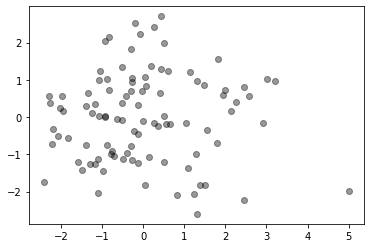

In [13]:
# plots top songs as scatter plot
plt.scatter(PCA_comp[0], PCA_comp[1], alpha=.4, color="black");

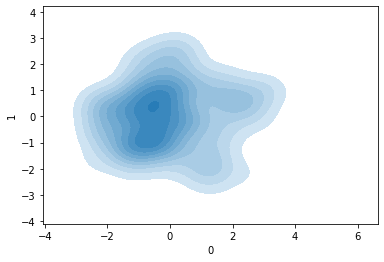

In [14]:
# plots density map similar to taste map in original article
sn.kdeplot(PCA_comp[0], PCA_comp[1], shade=True, shade_lowest=False);

### K-Means Clustering

Now that we have the songs visualized, we want to identify the different clusters of genres and artists I listen to. Here is where k-means comes into play. 

It works by initializing `k` number of centroids and assign each element to the nearest centroid. Then the centroids are moved to the center of all it's assigned points, then each element is assigned their nearest centroid again. The process repeats until an equilibrium is reached. 

With this method, we can find the various clusters in my top songs, and analyze them for trends. 

**Number of clusters**

Before running k-means, we have to decide on `k`, the number of clusters. The original article had 6 main clusters, and I'm tempted to do the same. To make sure this isn't a bad decision, we can verify it with the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). 

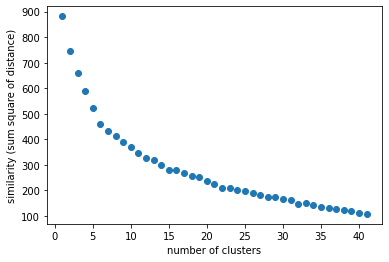

In [15]:
# Elbow Method
def ElbowPlot(scaled_features_df):
    ssds = [ ]
    for k in list(range(1,42)):
        kmeans = KMeans(n_clusters=k).fit(scaled_features_df.drop(["id"], axis = 1))
        ssds.append({"k": k, "ssd": kmeans.inertia_})

    ssds_df = pd.DataFrame(ssds)
    plt.scatter(ssds_df["k"], ssds_df["ssd"])
    plt.xlabel("number of clusters")
    plt.ylabel("similarity (sum square of distance)")

ElbowPlot(scaled_features_df)

We can see some sort of elbow around 6 or 7, which means that our pick was good enough. To double-check, we can also use the [Silhoutte method](https://en.wikipedia.org/wiki/Silhouette_(clustering)). This measures how similar an element is to its cluster compared to others from a scale of -1 to 1. 

**Running k-means**

In [16]:
k = 6

kmeans = KMeans(k).fit(
    scaled_features_df.drop(["id"], axis=1))
scaled_features_df["cluster"] = pd.Series(kmeans.labels_)

# Add metadata back to tracks
top_tracks_normalized_df = top_tracks_names.merge(scaled_features_df, on="id")

# preview the contents of a cluster
top_tracks_normalized_df[top_tracks_normalized_df["cluster"] == 0].head()

,name,id,artist,genres,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,cluster
3,The Wrong Direction,7FMEEYbIfiEazN02exf120,Passenger,"[folk-pop, neo mellow, pop, pop rock]",0.702521,0.185692,-0.541296,0.364582,-0.196854,-0.631464,2.036582,0.796460,0.445950,0
14,First Time,2Gl0FzuLxflY6nPifJp5Dr,Kygo,"[edm, pop, tropical house]",0.139190,-0.269254,1.525541,-0.316888,-0.196854,-0.553383,1.311210,-1.023590,-0.535013,0
17,Heart to Love,1pXy0rgUGQsaeaip4EN6gF,Passenger,"[folk-pop, neo mellow, pop, pop rock]",-1.017650,0.579159,-0.436296,-0.948166,-0.187873,-0.421246,0.783668,-0.596495,-0.388725,0
19,Reality,1Mys1gf9SkMBAVGGxpkJ7d,Lost Frequencies,"[belgian edm, edm, pop, tropical house]",0.954008,0.376278,-0.684979,-1.040389,-0.196832,-0.905349,0.849610,0.515824,-1.733174,0
29,Born To Be Yours,0kHyKhJMukHEPfeh8s7rdM,Kygo,"[edm, pop, tropical house]",0.692462,0.320947,-0.582743,0.103420,-0.196854,-0.562993,-0.055605,0.125488,-0.541703,0


From my knowledge of those songs, the clustering seems to have worked. Now to plot them!

**Plotting clusters**

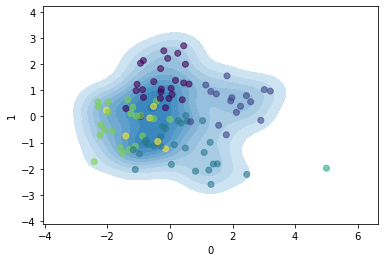

In [17]:
sn.kdeplot(PCA_comp[0], PCA_comp[1], shade=True, shade_lowest=False)
plt.scatter(PCA_comp[0], PCA_comp[1], alpha=.6,
                 c=top_tracks_normalized_df["cluster"].astype(float));

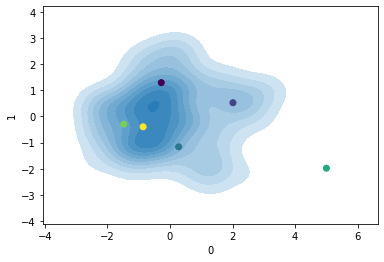

In [18]:
# plot cluster centroids
centers = np.array(kmeans.cluster_centers_)
principal_comp_centroids = pca.transform(
    centers)
PCA_comp_centroids = pd.DataFrame(principal_comp_centroids)

sn.kdeplot(PCA_comp[0], PCA_comp[1], shade=True, shade_lowest=False)
plt.scatter(PCA_comp_centroids[0], PCA_comp_centroids[1], c=PCA_comp_centroids.index.astype(float));

### Labelling Clusters

Now that we have plotted the centers of each cluster, we can label them based on their content. Right now, we can show the top genres of each cluster, and list the top artists to describe it. In the future, I'm looking into using deep learning methods to title the clusters based on song characteristics. 

**Get top artists and genres for each cluster**

In [19]:
# function to return dataframe with the artist frequency in each cluster
def getArtistCountDf(k, top_tracks_normalized_df):
    count_df = top_tracks_normalized_df[top_tracks_normalized_df["cluster"]
                                        == k].artist.value_counts().to_frame()
    count_df = count_df.rename(columns={"artist": "cluster_" + str(k)})
    count_df["name"] = count_df.index
    return count_df


# get total count of each artist in the data
artist_count_df = top_tracks_normalized_df.artist.value_counts().to_frame()
artist_count_df = artist_count_df.rename(columns={"artist": "total"})
artist_count_df['name'] = artist_count_df.index

# merge all cluster count together
for i in range(k):
    artist_count_df = artist_count_df.merge(getArtistCountDf(
        i, top_tracks_normalized_df), on="name", how="outer")
artist_count_df = artist_count_df.fillna(0)

# get artist and their respective genres from the main data,
# then join it with the artist count data
artist_genre_df = top_tracks_names.drop_duplicates("artist")[
    ["artist", "genres"]]
artist_count_df = artist_count_df.merge(
    artist_genre_df, left_on="name", right_on="artist")

artist_count_df.head()

,total,name,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,artist,genres
0,11,Kygo,2.0,1.0,5.0,0.0,1.0,2.0,Kygo,"[edm, pop, tropical house]"
1,8,Passenger,3.0,2.0,2.0,0.0,0.0,1.0,Passenger,"[folk-pop, neo mellow, pop, pop rock]"
2,8,Avicii,2.0,1.0,2.0,0.0,2.0,1.0,Avicii,"[big room, dance pop, edm, pop]"
3,4,Lost Frequencies,2.0,0.0,1.0,0.0,1.0,0.0,Lost Frequencies,"[belgian edm, edm, pop, tropical house]"
4,3,Chef'Special,1.0,1.0,1.0,0.0,0.0,0.0,Chef'Special,"[dutch indie, dutch pop, dutch rock, folk-pop]"


If we just look at the frequency of each artist in each cluster, Kygo would be high up in most of the clusters. For that reason, we have to find a different way to calculate the importance of each artist to each cluster. 

To normalize high numbers, I came up with the formula: 
$$\frac{frequencyInCluster^2}{artistTotal * clusterTotal}$$

This equation takes into account the proportion of an artist present in the cluster in addition to the proportion of the cluster that the artist takes up. Artists with only song will have a full 1 for the first and a low number for the second in a 20-ish song cluster, while artists with many songs will have a low number for the first, and a higher number for the second. 

In [20]:
# stores the size of each cluster for future use, since we're replacing the counts with percentages
cluster_sizes = []
for i in range(k):
    cluster_sizes.append(
        {
            "cluster": i,
            "total": artist_count_df['cluster_' + str(i)].sum()
        })

# replace the frequency with the percentage of the artist songs in each cluster
for i in range(k):
    artist_count_df['cluster_' + str(i)] = artist_count_df['cluster_' + str(i)]**2 / (
        artist_count_df.total * artist_count_df['cluster_' + str(i)].sum())

artist_count_df.head()

,total,name,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,artist,genres
0,11,Kygo,0.013986,0.005682,0.084175,0.0,0.004132,0.060606,Kygo,"[edm, pop, tropical house]"
1,8,Passenger,0.043269,0.031250,0.018519,0.0,0.000000,0.020833,Passenger,"[folk-pop, neo mellow, pop, pop rock]"
2,8,Avicii,0.019231,0.007812,0.018519,0.0,0.022727,0.020833,Avicii,"[big room, dance pop, edm, pop]"
3,4,Lost Frequencies,0.038462,0.000000,0.009259,0.0,0.011364,0.000000,Lost Frequencies,"[belgian edm, edm, pop, tropical house]"
4,3,Chef'Special,0.012821,0.020833,0.012346,0.0,0.000000,0.000000,Chef'Special,"[dutch indie, dutch pop, dutch rock, folk-pop]"


In [21]:
# function to count frequency of each genre in top artists of cluster
# then return an array of the top genres
def findBestGenre(genres):
    g = defaultdict(int)
    for row in genres:
        for genre in row:
            g[genre] += 1
    return sorted(g, key=g.get, reverse=True)

# limit array to n elements
def listLimit(n, lst):
    return lst if len(lst) < n else lst[:n]


# get top genres and artists and store them in arrays
genre_groups = []
artist_groups = []
for i in range(k):
    cluster_artists_sort = artist_count_df.nlargest(
        10, columns=['cluster_' + str(i)])
    cluster_artists = cluster_artists_sort[cluster_artists_sort["cluster_" + str(
        i)] > 0]
    mygenres = findBestGenre(cluster_artists["genres"])
    genre_groups.append(mygenres)
    artist_groups.append(cluster_artists['name'].values)

# print each labelled cluster
for i in range(k):
    print("{}. {}\n{}\n".format(i, "/".join(listLimit(2, genre_groups[i])),
                            "\n".join(listLimit(3, artist_groups[i]))))

0. neo mellow/pop
Passenger
Lost Frequencies
Tropixx

1. pop/indiecoustica
Juke Ross
Krezip
Eklo

2. indie rock/modern rock
Train
Kygo
Saint Motel

3. 
AT8

4. pop/tropical house
Cheat Codes
Kodaline
Saint James

5. pop/neo mellow
Matthew Mole
John Mayer
Kygo



**Annotate cluster centroid plot with genres and artists**

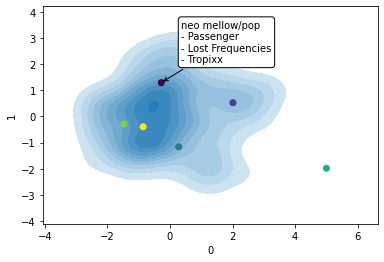

In [22]:
# set up plot
fig, ax = plt.subplots()

# function to add annotation to cluster i
def annotateCluster(i):
    xy = (PCA_comp_centroids[0][i], PCA_comp_centroids[1][i])
    text = "{}\n- {}".format(
        "/".join(listLimit(2, genre_groups[i])), "\n- ".join(listLimit(3, artist_groups[i])))
    ax.annotate(text, xy=xy, xytext=(20, 20), textcoords="offset points",
                bbox=dict(boxstyle="round", fc="w"),
                arrowprops=dict(arrowstyle="->"))

    
sn.kdeplot(PCA_comp[0], PCA_comp[1], shade=True, shade_lowest=False)
plt.scatter(PCA_comp_centroids[0], PCA_comp_centroids[1], c=PCA_comp_centroids.index.astype(float))

# show annotation for cluster_0
annotateCluster(0);

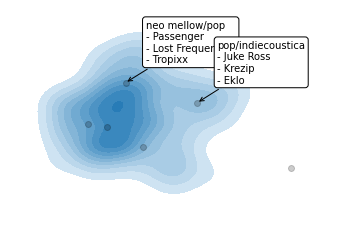

In [23]:
# clean illustration of taste map
fig, ax = plt.subplots()
sn.kdeplot(PCA_comp[0], PCA_comp[1], shade=True, shade_lowest=False)
plt.axis("off")
plt.scatter(PCA_comp_centroids[0], PCA_comp_centroids[1], alpha=0.2, c="black")

# show annotations for cluster 0 and 1
annotateCluster(0);
annotateCluster(1);

With the taste map done, we can plot the genre groups graph making use of this data. To do this we'll sort the clusters by size, and get the most popular genres in each cluster. 

In [24]:
# get clusters sorted by size
cluster_sizes = sorted(
    cluster_sizes, key=lambda cluster: cluster["total"], reverse=True)

# Plots packed circle chart with top genres
uniq_genres = []
set_length = 0
cluster_genres = []
size_diff = 6
circ_size = k*size_diff + size_diff

# from largest cluster to smallest cluster, find the most common genres in each cluster
# also set the circles to less extreme sizes, with a uniform difference
for i in range(k):
    ind = cluster_sizes[i]["cluster"]
    cluster_sizes[i]["size"] = circ_size
    circ_size -= size_diff
    for genre in genre_groups[ind]:
        if genre not in uniq_genres:
            uniq_genres.append(genre)
        if len(uniq_genres) - set_length >= 3:
            break
    cluster_genres.append(uniq_genres[set_length:])
    set_length = len(uniq_genres)

Then, we'll format the genres and plot it with the `circlify` library we imported at the start. 

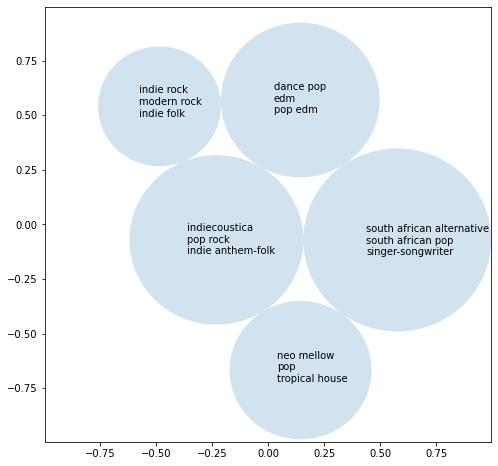

In [25]:
# format the genre string and remove clusters with no genres
def formatGenreText(genres):
    for i in range(len(genres)):
        if len(genres[i]) > 0:
            genres[i] = "\n".join(genres[i])
    return [cluster for cluster in genres if cluster != []]


# remove circles that have no genres from the plot
genre_data = []
for i in range(k):
    if len(cluster_genres[i]) > 0:
        genre_data.append(cluster_sizes[i])

circles = circ.circlify(genre_data, datum_field="size", id_field="labels")
circ.bubbles(circles, labels=formatGenreText(cluster_genres))

There we have it. We ware able to recreate the plot from the article, complete with the labelling of each cluster with the top genres and artists. Next, I'll be looking to recreate this in JavaScript, and also explore the collaborative filtering part of the algorithm!